In [186]:
from pomegranate.callbacks import History, ModelCheckpoint
from pomegranate import *

import matplotlib.pyplot as plt
from matplotlib import transforms

import pysam
import pandas as pd
import numpy as np

import re
import math

In [2]:
def make_global_alignment_model(target, name = None):
    model = HiddenMarkovModel(name = name)
    s = {}
    
    # add states
    i0 = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name=f"{name}:I0")

    model.add_state(i0)
    
    s[i0.name] = i0
    
    for c in range(len(target)):
        dc = State(None, name=f"{name}:D{c+1}")
        
        mc = State(DiscreteDistribution({
            "A": 0.94 if target[c] == 'A' else 0.02,
            "C": 0.94 if target[c] == 'C' else 0.02,
            "G": 0.94 if target[c] == 'G' else 0.02,
            "T": 0.94 if target[c] == 'T' else 0.02,
        }), name=f"{name}:M{c+1}")
        
        ic = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name=f"{name}:I{c+1}")

        model.add_states([mc, ic, dc])
        
        s[dc.name] = dc
        s[mc.name] = mc
        s[ic.name] = ic
                
    # add transitions
    model.add_transition(model.start, s[f'{name}:I0'], 0.05)
    model.add_transition(model.start, s[f'{name}:D1'], 0.05)
    model.add_transition(model.start, s[f'{name}:M1'], 0.90)
    
    model.add_transition(s[f'{name}:I0'], s[f'{name}:I0'], 0.70)
    model.add_transition(s[f'{name}:I0'], s[f'{name}:D1'], 0.15)
    model.add_transition(s[f'{name}:I0'], s[f'{name}:M1'], 0.15)
    
    for c in range(1, len(target)):
        model.add_transition(s[f'{name}:D{c}'], s[f'{name}:D{c+1}'], 0.15)
        model.add_transition(s[f'{name}:D{c}'], s[f'{name}:I{c}'],   0.70)
        model.add_transition(s[f'{name}:D{c}'], s[f'{name}:M{c+1}'], 0.15)
        
        model.add_transition(s[f'{name}:I{c}'], s[f'{name}:D{c+1}'], 0.15)
        model.add_transition(s[f'{name}:I{c}'], s[f'{name}:I{c}'],   0.15)
        model.add_transition(s[f'{name}:I{c}'], s[f'{name}:M{c+1}'], 0.70)

        model.add_transition(s[f'{name}:M{c}'], s[f'{name}:D{c+1}'], 0.05)
        model.add_transition(s[f'{name}:M{c}'], s[f'{name}:I{c}'],   0.05)
        model.add_transition(s[f'{name}:M{c}'], s[f'{name}:M{c+1}'], 0.90)
    
    model.add_transition(s[f'{name}:D{len(target)}'], s[f'{name}:I{len(target)}'], 0.70)
    model.add_transition(s[f'{name}:D{len(target)}'], model.end, 0.30)

    model.add_transition(s[f'{name}:I{len(target)}'], s[f'{name}:I{len(target)}'], 0.15)
    model.add_transition(s[f'{name}:I{len(target)}'], model.end, 0.85)

    model.add_transition(s[f'{name}:M{len(target)}'], s[f'{name}:I{len(target)}'], 0.90)
    model.add_transition(s[f'{name}:M{len(target)}'], model.end, 0.10)
    
    model.bake(merge = 'None')
    
    return model

In [3]:
def make_random_repeat_model(name = 'random'):
    model = HiddenMarkovModel(name = name)
    
    # add states
    ri = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name=f"{name}:RI")
    rda = State(None, name=f"{name}:RDA")
    rdb = State(None, name=f"{name}:RDB")
    
    model.add_states([ri, rda, rdb])
    
    # add transitions
    model.add_transition(model.start, rda, 0.5)
    model.add_transition(model.start, ri, 0.5)
    
    model.add_transition(ri, ri, 0.8)
    model.add_transition(ri, rda, 0.10)
    model.add_transition(ri, model.end, 0.10)
    
    model.add_transition(rdb, ri, 0.5)
    model.add_transition(rdb, model.end, 0.5)
    
    model.bake(merge = 'None')
    
    return model

In [4]:
def build_full_model(adapters, direct_connections):
    full_model = make_random_repeat_model()
    for k in adapters:
        full_model.add_model(make_global_alignment_model(adapters[k], k))
        
    full_model.bake(merge = 'None')

    # dictionary of model starting states, random start, and random end
    starts = {}
    rda = None
    rdb = None
    for s in full_model.states:
        if "-start" in s.name and "random" not in s.name:
            starts[re.sub("-start", "", s.name)] = s
        elif "random:RDA" in s.name:
            rda = s
        elif "random:RDB" in s.name:
            rdb = s

    # link rda to starts
    for sname in starts:
        full_model.add_transition(rda, starts[sname], 1.0/len(starts))
            
    # link up ending states according to our direct connections dictionary
    for s in full_model.states:
        m = re.match("^(\w+):([MID])(\d+)", s.name)
        if m is not None and int(m.group(3)) == len(adapters[m.group(1)]):
            sname = m.group(1)
            
            if sname in direct_connections:
                p = 1.0/(10*len(direct_connections[sname]))
                full_model.add_transition(s, rdb, p)
                
                for dcname in direct_connections[sname]:
                    full_model.add_transition(s, starts[dcname], (1.0 - p)/len(direct_connections[sname]))
            else:
                full_model.add_transition(s, rdb, 0.5)
                
    full_model.bake()
    
    return full_model

In [5]:
def plot(model):
    l = {}
    for s in model.states:
        l[s] = s.name

    model.plot(labels=l)

In [393]:
def smooth(path, radius=5):
    p = 0

    while p < len(path):
        # Are we in an adapter (as opposed to just the random model)?
        if path[p] in adapters:
            # We are!  How far does it extend?
            p_adapter_left = p - 1
            while p_adapter_left >= 0 and path[p_adapter_left] == path[p]:
                p_adapter_left = p_adapter_left - 1
                
            p_adapter_right = p + 1
            while p_adapter_right < len(path) and path[p_adapter_right] == path[p]:
                p_adapter_right = p_adapter_right + 1
                
            # Now check if this is an adapter island (the surrounding states are just the random model)
            prev_label = None
            if p_adapter_left - radius >= 0:
                prev_labels = set(path[(p_adapter_left - 1 - radius):(p_adapter_left - 1)])
                if len(prev_labels) == 1:
                    prev_label = next(iter(prev_labels))
                    
            next_label = None
            if p_adapter_right + radius < len(path):
                next_labels = set(path[(p_adapter_right + 1):(p_adapter_right + 1 + radius)])
                if len(next_labels) == 1:
                    next_label = next(iter(next_labels))

            # Are we an island?
            if prev_label == next_label and prev_label == 'random':
                for q in range(p_adapter_left, p_adapter_right):
                    path[q] = 'random'
                
            p = p_adapter_right
        
        p += 1
        
    return path

In [394]:
def annotate(full_model, seq, smooth_islands=True):
    logp, path = full_model.viterbi(seq)

    ppath = []
    for p, (idx, state) in enumerate(path[1:-1]):
        if "start" not in state.name and ":RD" not in state.name and ":D" not in state.name:
            ppath.append(f'{re.split(":", state.name)[0]}')
            
    if smooth_islands:
        ppath = smooth(ppath)
                
    return logp, ppath

In [7]:
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)

    return bases

In [8]:
# with pysam.FastxFile("sirv.fasta") as fh:
#     for q in fh:
#         adapters[q.name] = q.sequence

In [10]:
def inspect_transitions_from(model, state_name):
    q = model.dense_transition_matrix()

    a = pd.DataFrame(q, columns=[x.name for x in model.states])
    a.index = [x.name for x in model.states]

    for s in model.states:
        q = a.loc[state_name, s.name]
        if q > 0.0:
            print(f'{state_name} -> {s.name} = {q}')


def inspect_transitions_to(model, state_name):
    q = model.dense_transition_matrix()

    a = pd.DataFrame(q, columns=[x.name for x in model.states])
    a.index = [x.name for x in model.states]

    for s in model.states:
        q = a.loc[s.name, state_name]
        if q > 0.0:
            print(f'{s.name} -> {state_name} = {q}')


# print("from:")
# inspect_transitions_to(full_model, "3p_Adapter:M25")

# print("to:")
# inspect_transitions_from(full_model, "3p_Adapter:M25")

In [11]:
adapters = {
    "10x_Adapter": "TCTACACGACGCTCTTCCGATCT",
    "5p_TSO": "TTTCTTATATGGG",
    "Poly_A": "AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA",
    "3p_Adapter": "GTACTCTGCGTTGATACCACTGCTT",
    "A": "AGCTTACTTGTGAAGA",
    "B": "ACTTGTAAGCTGTCTA",
    "C": "ACTCTGTCAGGTCCGA",
    "D": "ACCTCCTCCTCCAGAA",
    "E": "AACCGGACACACTTAG",
    "F": "AGAGTCCAATTCGCAG",
    "G": "AATCAAGGCTTAACGG",
    "H": "ATGTTGAATCCTAGCG",
    "I": "AGTGCGTTGCGAATTG",
    "J": "AATTGCGTAGTTGGCC",
    "K": "ACACTTGGTCGCAATC",
    "L": "AGTAAGCCTTCGTGTC",
    "M": "ACCTAGATCAGAGCCT",
    "N": "AGGTATGCCGGTTAAG",
    "O": "AAGTCACCGGCACCTT",
    "P": "ATGAAGTGGCTCGAGA"
}

direct_connections = {
    "Poly_A": ["3p_Adapter"],
    "3p_Adapter": ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P"],
    "A": ["10x_Adapter"],
    "B": ["10x_Adapter"],
    "C": ["10x_Adapter"],
    "D": ["10x_Adapter"],
    "E": ["10x_Adapter"],
    "F": ["10x_Adapter"],
    "G": ["10x_Adapter"],
    "H": ["10x_Adapter"],
    "I": ["10x_Adapter"],
    "J": ["10x_Adapter"],
    "K": ["10x_Adapter"],
    "L": ["10x_Adapter"],
    "M": ["10x_Adapter"],
    "N": ["10x_Adapter"],
    "O": ["10x_Adapter"],
    "P": ["10x_Adapter"]
}

In [12]:
untrained_model = build_full_model(adapters, direct_connections)

with open("untrained.yaml", "w") as model_file:
    print(untrained_model.to_yaml(), file=model_file)

In [13]:
def get_training_samples(bamfile, untrained_model, num_samples = 100):
    samfile = pysam.AlignmentFile(bamfile, "rb", check_sq=False)

    seqs = []
    for read in samfile:
        flogp = -math.inf
        fseq = None

        # Use the untrained model to determine if we should add this training
        # example in the forward or reverse-complement orientation.
        for seq in [read.query_sequence, reverse_complement(read.query_sequence)]:
            logp, ppath = annotate(untrained_model, seq)

            if logp > flogp:
                flogp = logp
                fseq = seq

        seqs.append(list(fseq))

        if len(seqs) >= num_samples:
            break

    return seqs

In [14]:
bamfile = "SM-KM1PN.m64020_201213_022403.corrected.bam"            
seqs = get_training_samples(bamfile, untrained_model)

In [15]:
len(seqs)

100

In [16]:
trained_model = untrained_model.copy()

# improvement, history = trained_model.fit(sequences=seqs,
#                                          max_iterations=2,
#                                          stop_threshold=1e-1,
#                                          return_history=True,
#                                          verbose=True,
#                                          n_jobs=2,
#                                          callbacks=[ModelCheckpoint(name="annmas")])

# with open("trained.yaml", "w") as model_file:
#     print(trained_model.to_yaml(), file=model_file)

In [395]:
samfile = pysam.AlignmentFile(bamfile, "rb", check_sq=False)

i = 0
for read in samfile:
    flogp = -math.inf
    for seq in [read.query_sequence, reverse_complement(read.query_sequence)]:
        logp, ppath = annotate(trained_model, seq)
                
        if logp > flogp:
            flogp = logp
            fppath = ppath

    print(read.query_name)
    print(flogp)
    #print("".join(fppath))
    #print("")
        
    i += 1
    
    if i > 0:
        break
        
samfile.close()

m64020_201213_022403/1/ccs
-14713.179016218422


In [400]:
def highlight_state_sequence(strings, colors, labels, **kwargs):
    f = plt.figure(figsize=(24, 24))
    
    ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas
    
    f.suptitle(read.query_name, fontsize=16)
    
    f.patch.set_visible(False)
    ax.axis('off')
    
    columns = 150
    rows = 4*80
    
    plt.xlim([0, columns])
    plt.ylim([0, rows])

    letters_seen = 0
    row = 0
    column = 0
    for s, c, l in zip(strings, colors, labels):
        text = ax.text(0.5 + column*1.2, rows - row, s, color=c, transform=t, bbox=dict(facecolor='none', edgecolor=c), **kwargs)

        # Write classified sequence
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(
            text.get_transform(), x=ex.width, units='dots')
        
        # Write class label
        ax.text(0.5 + column*1.3 - (len(s)/2), rows - row - 3, l, transform=t, va='bottom', ha='center', fontsize=8, bbox=dict(facecolor='white', edgecolor='black'))

        # Decide whether we need to break into a new row
        letters_seen += len(s)
        column += 1
        
        if letters_seen >= columns:
            letters_seen = 0
            
            row += 1
            column = 0
            
            text = ax.text(column, row, "")
            text.draw(canvas.get_renderer())
            t = transforms.offset_copy(
                text.get_transform(), x=0, y=-30*row, units='dots')
            
    plt.savefig('test.png', bbox_inches='tight')

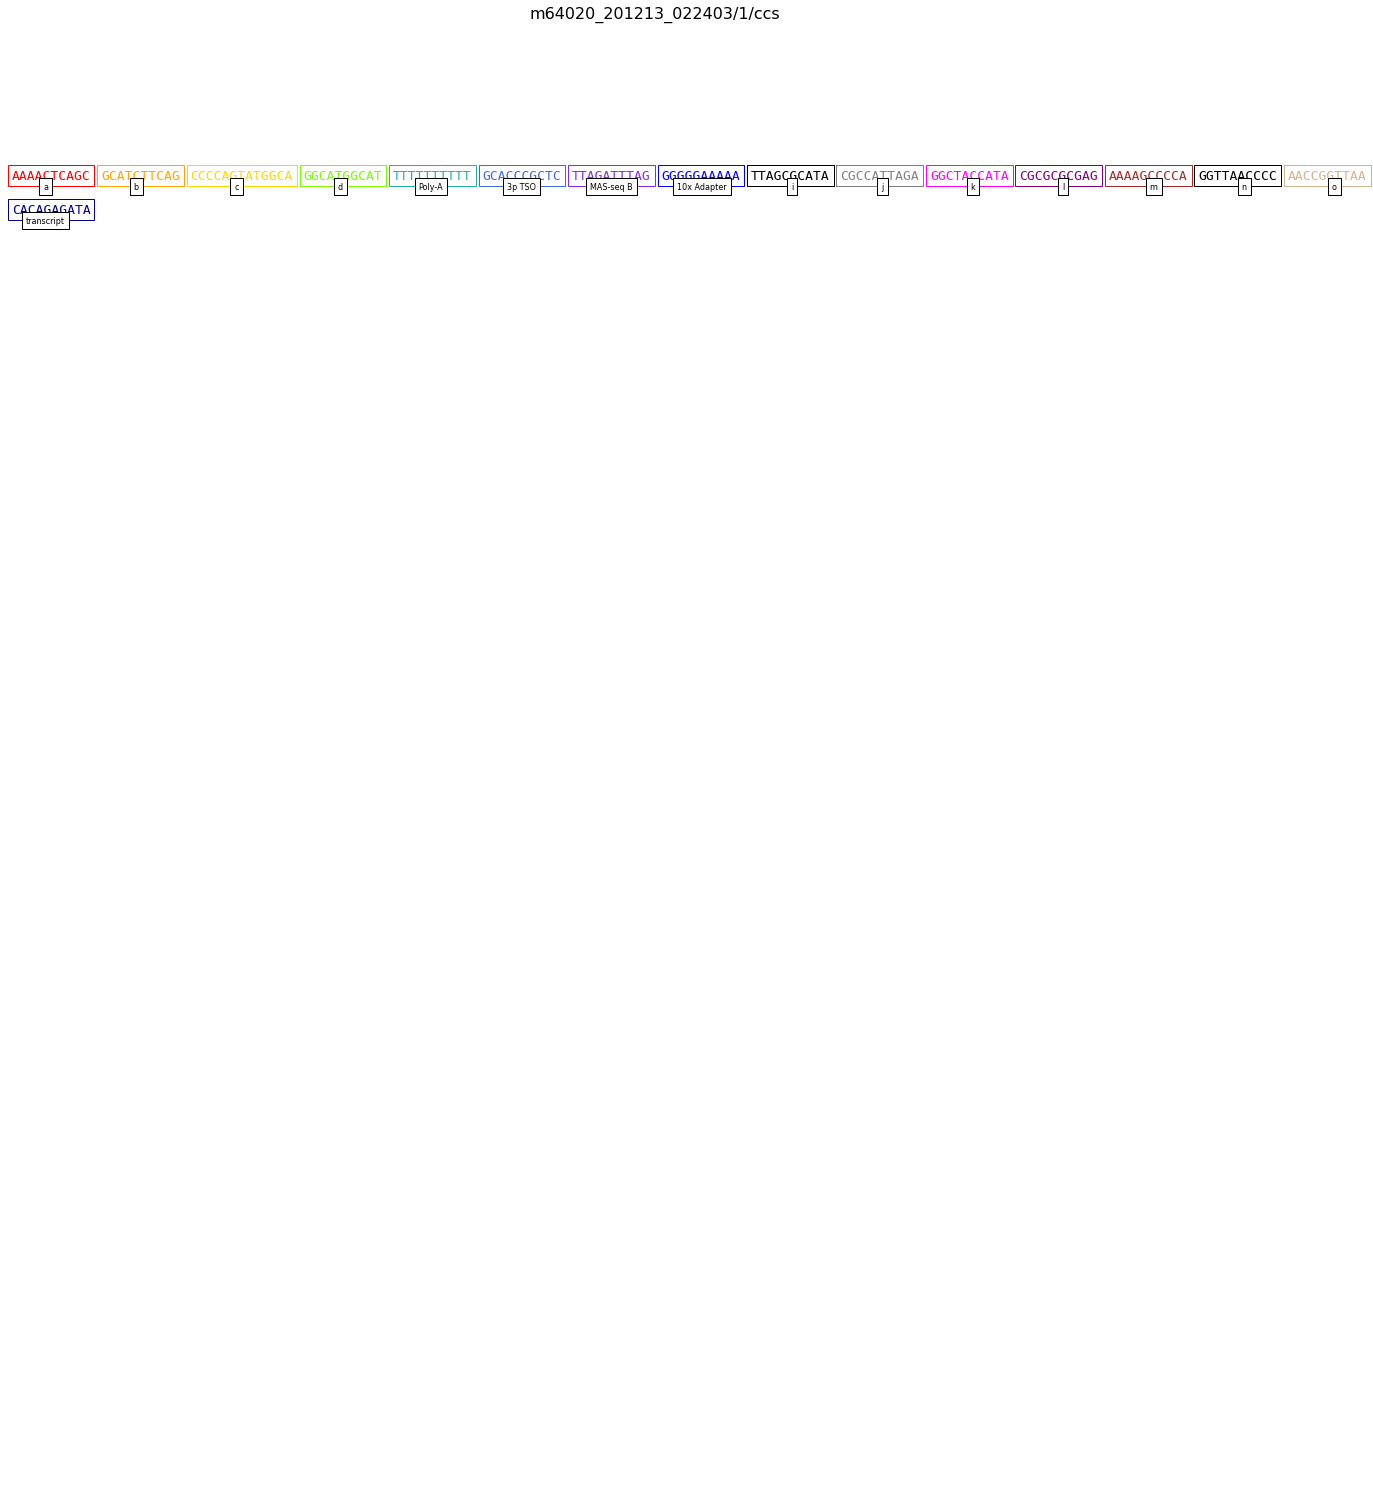

In [402]:
words = "AAAACTCAGC GCATCTTCAG CCCCAGTATGGCA GGCATGGCAT TTTTTTTTTT GCACCCGCTC TTAGATTTAG GGGGGAAAAA TTAGCGCATA CGCCATTAGA GGCTACCATA CGCGCGCGAG AAAAGCCCCA GGTTAACCCC AACCGGTTAA CACAGAGATA CCCAGATATAGTTAAAAGAT".split()
colors = ['red', 'orange', 'gold', 'lawngreen', 'lightseagreen', 'royalblue', 'blueviolet', 'blue', 'black', 'grey', 'magenta', 'purple', 'brown', 'black', 'tan', 'darkblue']
labels = ['a', 'b', 'c', 'd', 'Poly-A', '3p TSO', 'MAS-seq B', '10x Adapter', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'transcript']

highlight_state_sequence(words, colors, labels, size=13, family='monospace')
#split_lists(words, colors, labels, columns=15)

In [397]:
len(fppath)

10032

In [387]:
len(seq)

10032

In [398]:
color_hash = {
    "10x_Adapter": "blue",
    "5p_TSO": "blue",
    "Poly_A": "green",
    "3p_Adapter": "gold",
    "A": "red",
    "B": "red",
    "C": "red",
    "D": "red",
    "E": "red",
    "F": "red",
    "G": "red",
    "H": "red",
    "I": "red",
    "J": "red",
    "K": "red",
    "L": "red",
    "M": "red",
    "N": "red",
    "O": "red",
    "P": "red",
    "random": "darkgrey"
}

labelled_bases = []
state_labels = []
state_colors = []

bases = []
label = fppath[0]
al = 0
for i, (a, b) in enumerate(zip(list(seq), fppath)):
    if label == b:
        if al + len(a) < 150:
            #print(f'{i} {a} {b} aaa {al}')
    
            bases.append(a)
            label = b
            al += len(a)
        else:
            #print(f'{i} {a} {b} bbb {al}')
            
            labelled_bases.append("".join(bases))
            state_labels.append(label)
            state_colors.append(color_hash[label])

            bases = [a]
            label = b
            al = 0            
    else:
        #print(f'{i} {a} {b} ccc {al}')
            
        labelled_bases.append("".join(bases))
        state_labels.append(label)
        state_colors.append(color_hash[label])

        bases = [a]
        label = b
        #al = 0

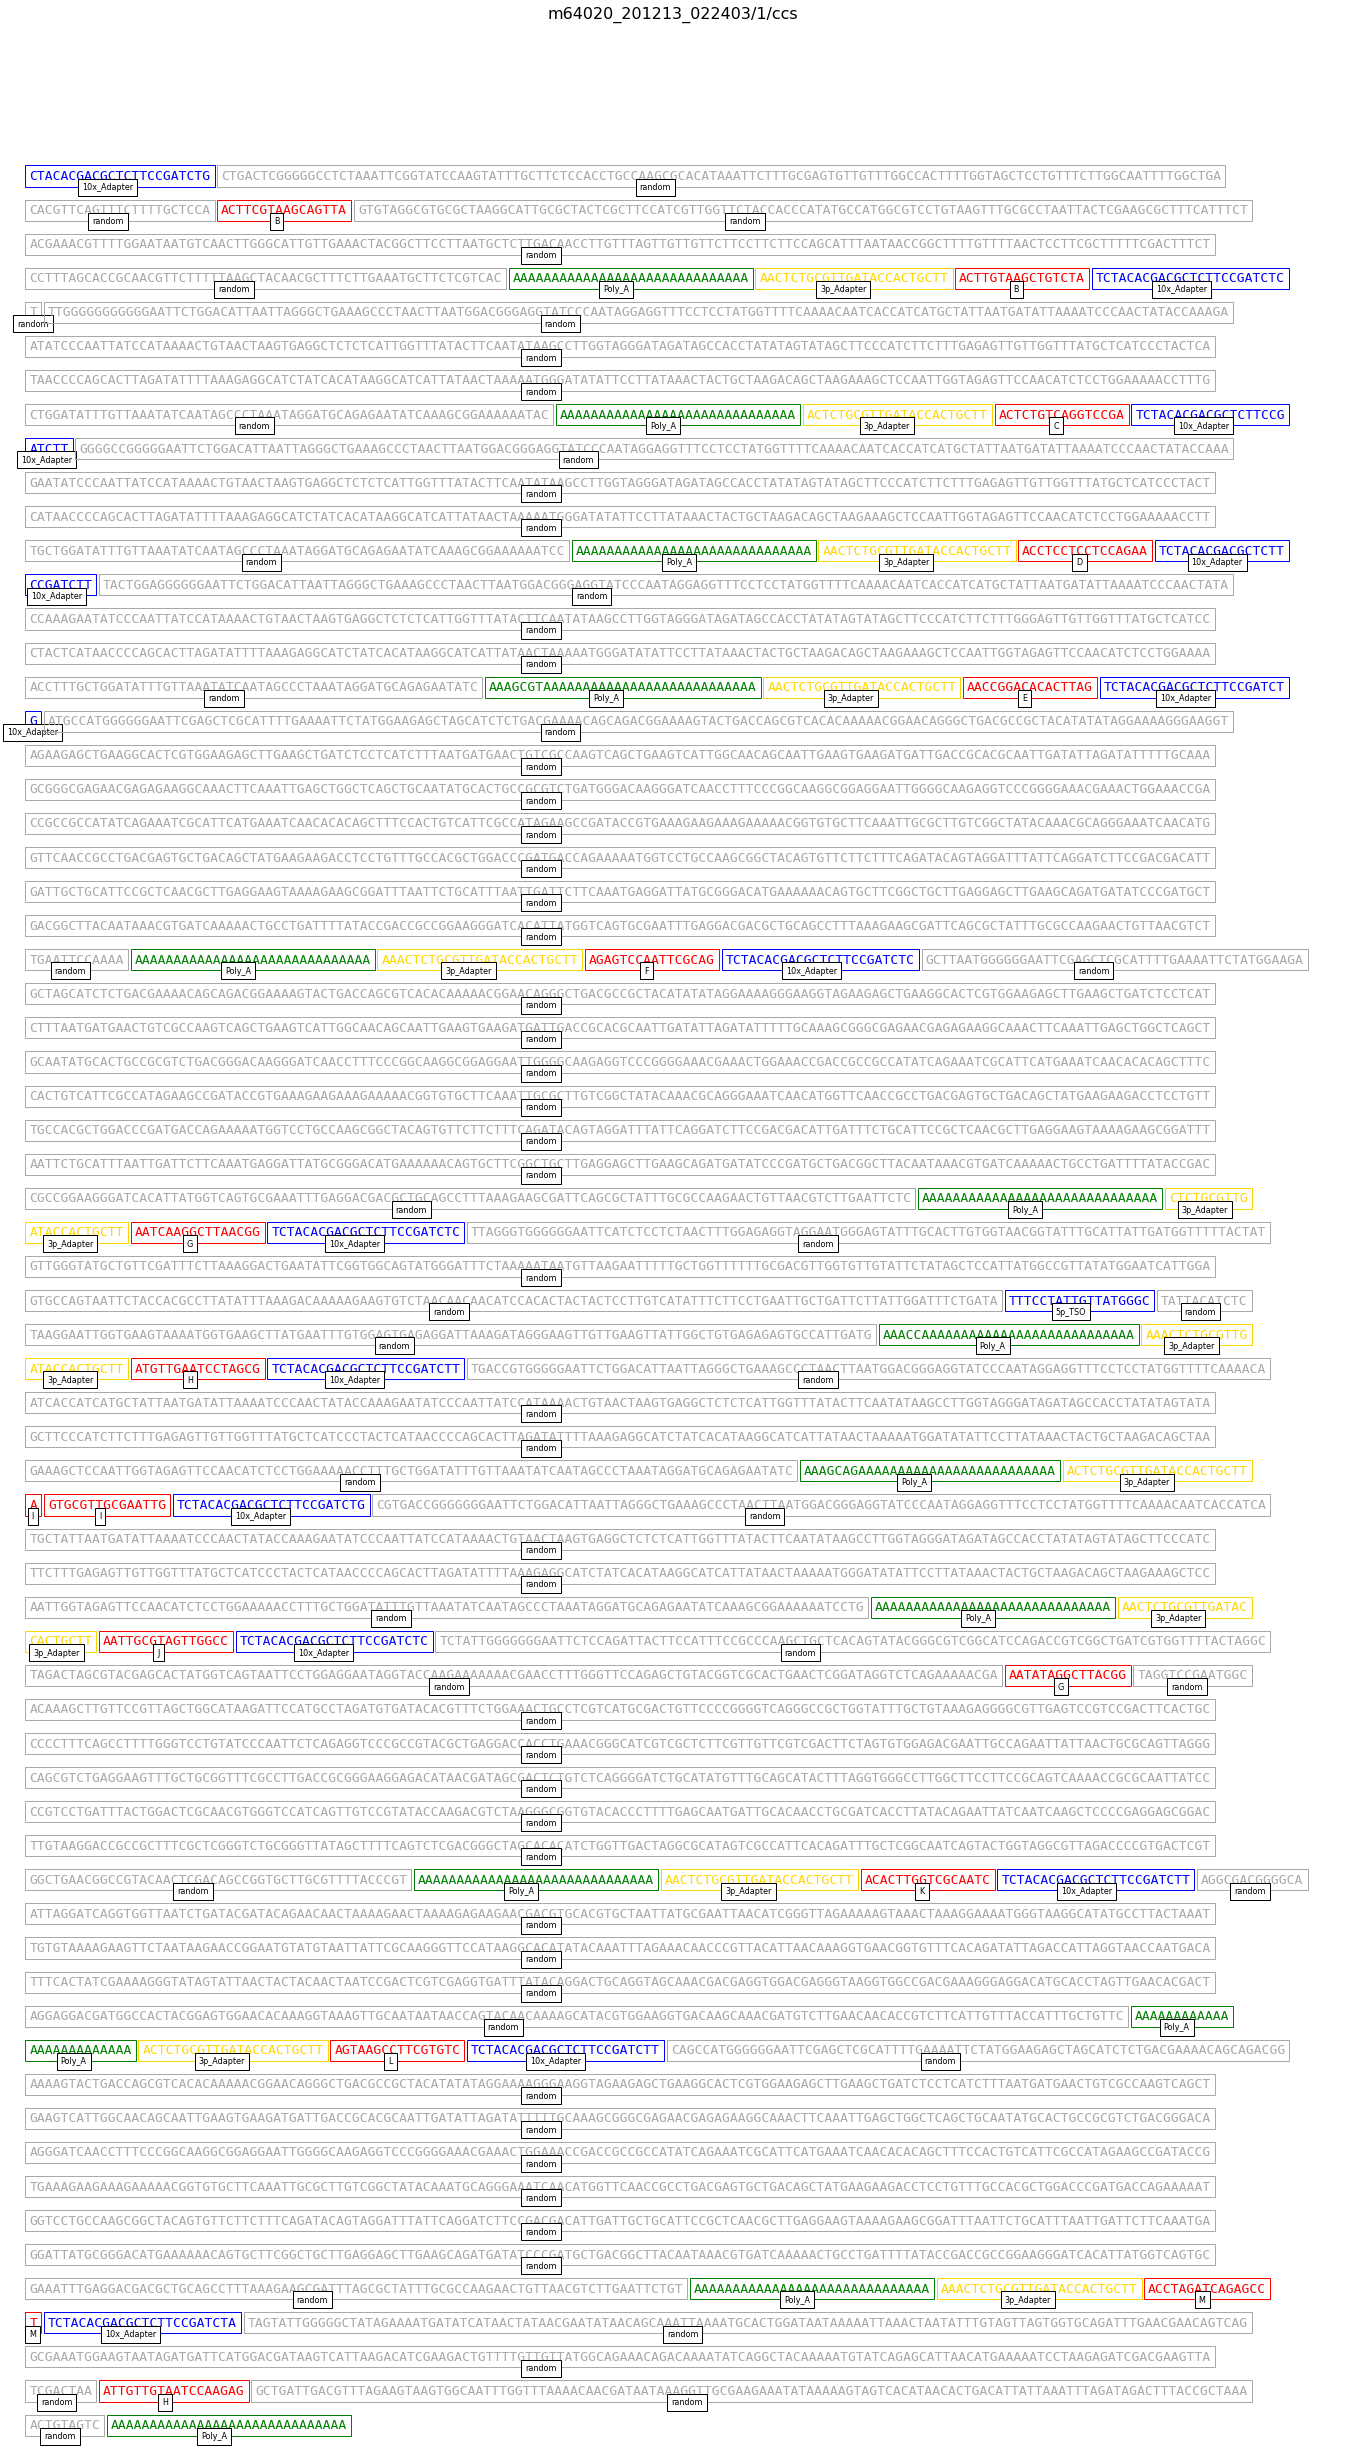

In [368]:
highlight_state_sequence(labelled_bases, state_colors, state_labels, size=13, family='monospace')

In [351]:
len(labelled_bases)

122

In [352]:
len(state_labels)

122

In [369]:
for a, b, c in zip(labelled_bases, state_labels, colors):
    print(f'{len(a)} {b}')

23 10x_Adapter
127 random
23 random
16 B
113 random
150 random
60 random
30 Poly_A
24 3p_Adapter
16 B
24 10x_Adapter
1 random
150 random
150 random
150 random
66 random


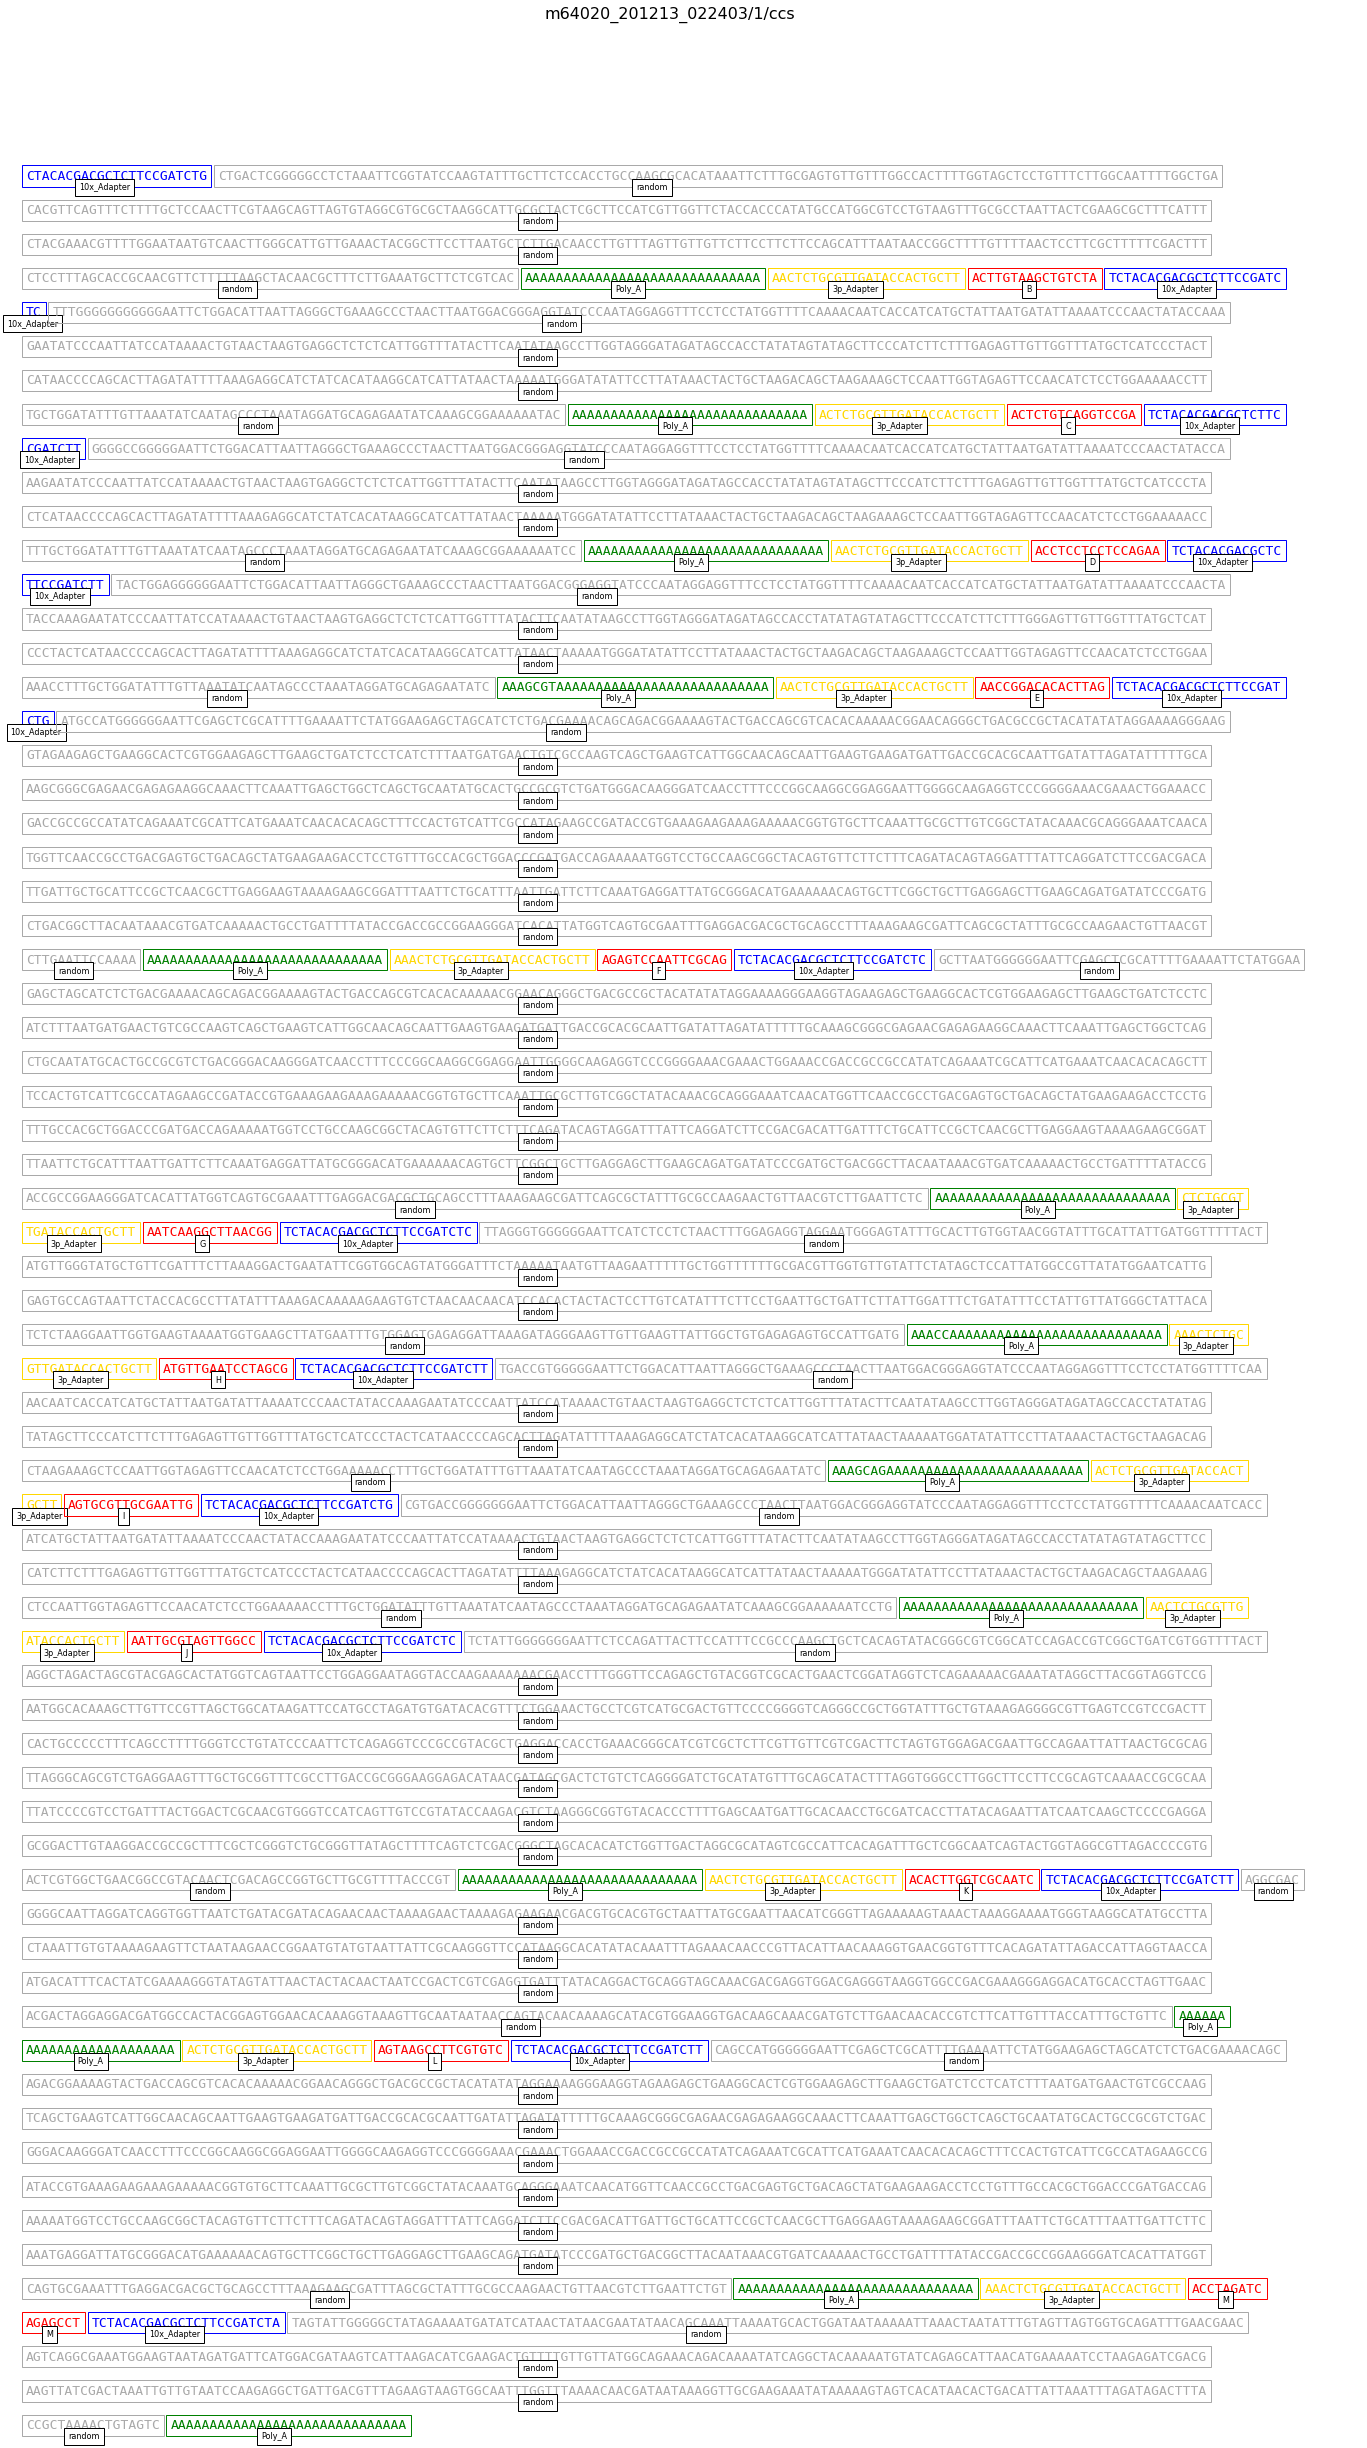

In [399]:
highlight_state_sequence(labelled_bases, state_colors, state_labels, size=13, family='monospace')